### Question 1

In [2]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
az.style.use('arviz-darkgrid')
plt.rcParams['figure.dpi'] = 300

random_seed = 730612
cores = 4

In [5]:
CHD_df = pd.read_csv("CHDdata.csv")

pd.DataFrame.head(CHD_df)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [ ]:
# Summary by group label

CHD_df[["chd", "ldl"]].groupby("chd").agg({"mean", "std", "count"})


ldl                    
    count      mean       std
chd                          
0     302  4.344238  1.870444
1     160  5.487938  2.225073

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

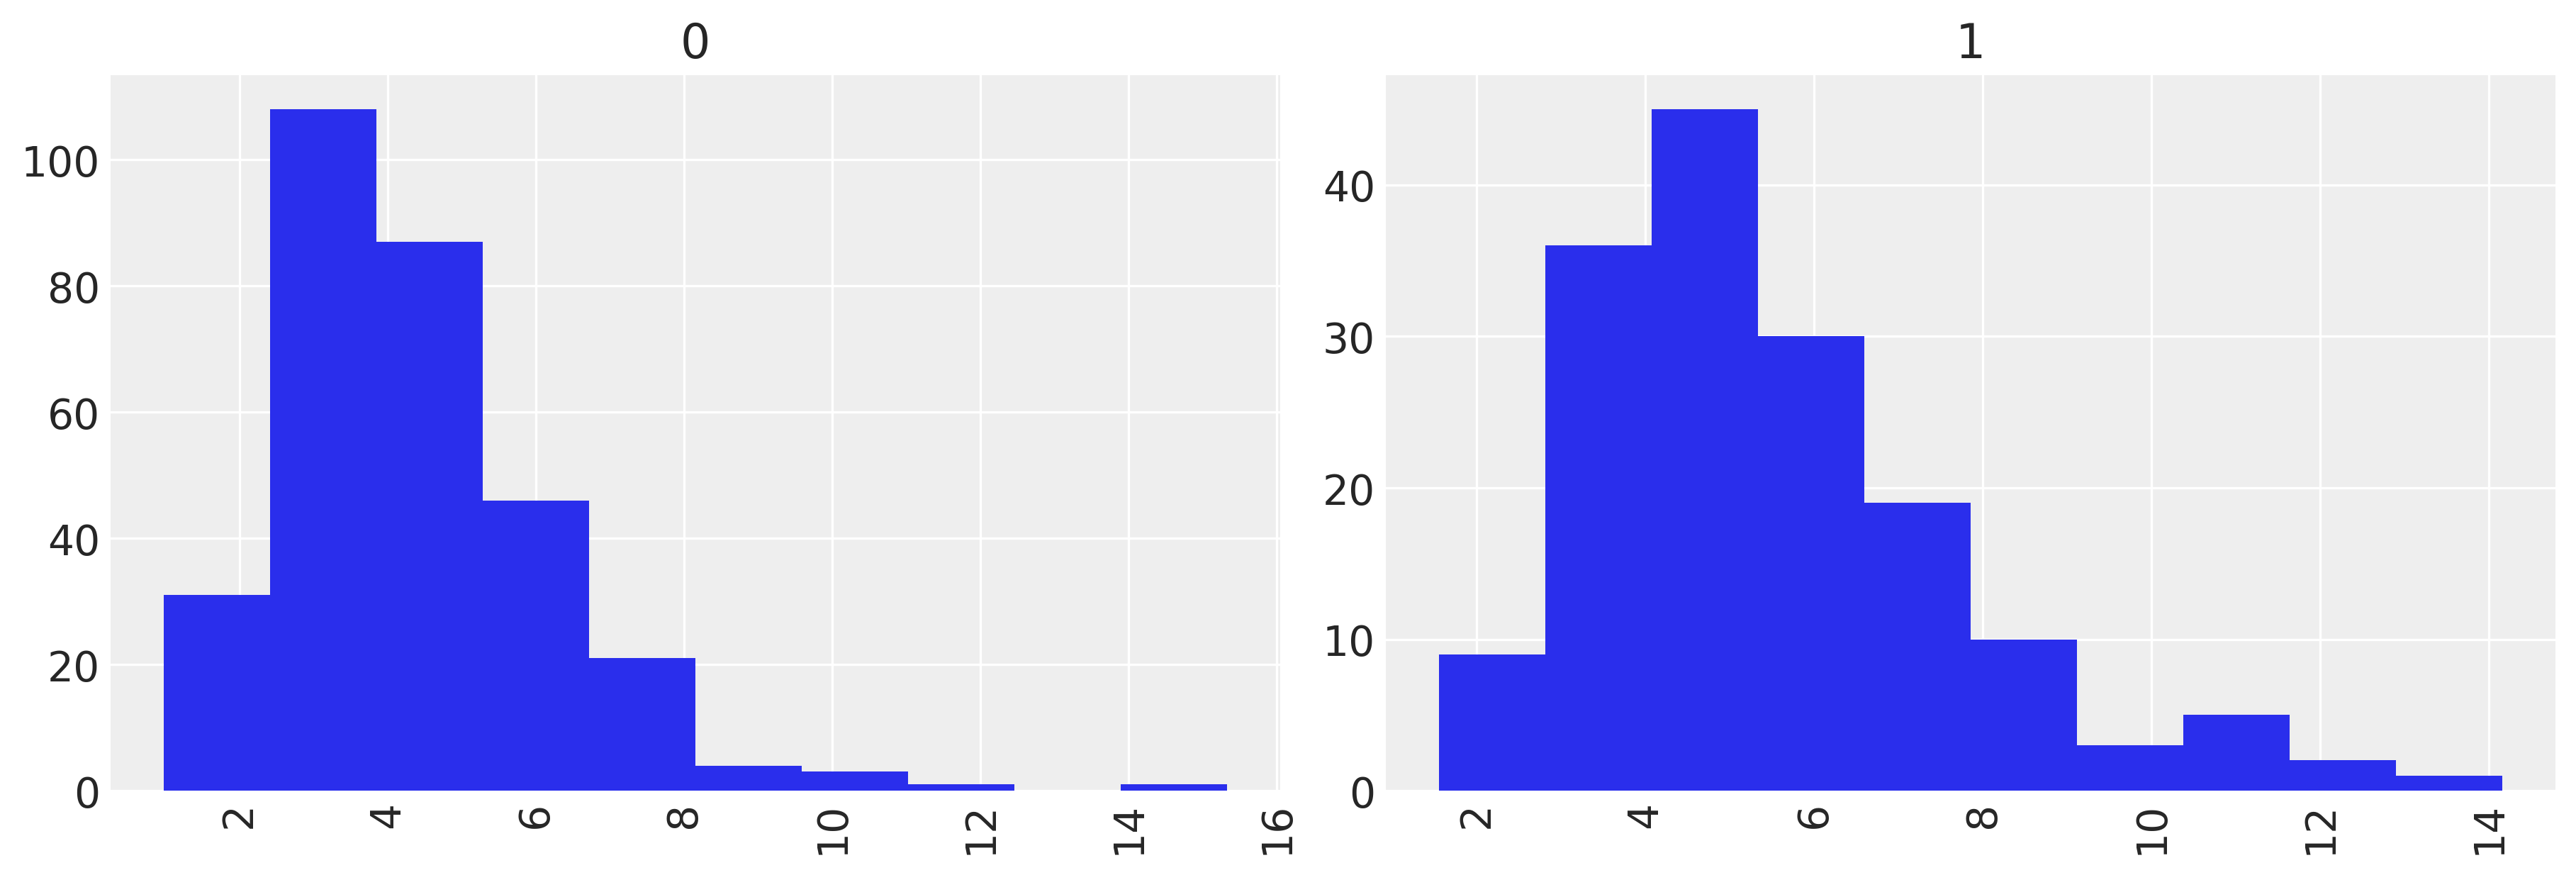

In [7]:
LDL_df = CHD_df[["ldl", "chd"]]
LDL_df.hist("ldl", by="chd", figsize=(12, 4))

In [8]:
y0 = LDL_df.loc[LDL_df["chd"]==0]['ldl']
y1 = LDL_df.loc[LDL_df["chd"]==1]['ldl']

In [9]:
#mean prior
μ_prior = CHD_df['ldl'].mean()
σ_prior = CHD_df['ldl'].std() * 2

#Std prior
σ_low = 1
σ_high = 100

with pm.Model() as model:
    CHD0_mean = pm.Normal("CHD0_mean", mu=μ_prior, sigma=σ_prior)
    CHD1_mean = pm.Normal("CHD1_mean", mu=μ_prior, sigma=σ_prior)
    CHD0_std = pm.Uniform("CHD0_std", lower=σ_low, upper=σ_high)
    CHD1_std = pm.Uniform("CHD1_std", lower=σ_low, upper=σ_high)
    ν = pm.Exponential("ν", 1/29)
    CHD0 = pm.StudentT("No_CHD", nu=ν, mu=CHD0_mean, sigma=CHD0_std, observed=y0)
    CHD1 = pm.StudentT("CHD", nu=ν, mu=CHD1_mean, sigma=CHD1_std, observed=y1)
    diff_of_means = pm.Deterministic("difference of means", CHD0_mean - CHD1_mean)
    diff_of_stds = pm.Deterministic("difference of stds", CHD0_std - CHD1_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((CHD0_std ** 2 + CHD1_std ** 2) / 2)
    )

    chd_trace=pm.sample(random_seed = random_seed, cores = cores)

array([[<Axes: title={'center': 'CHD0_mean'}>,
        <Axes: title={'center': 'CHD0_mean'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'CHD1_mean'}>,
        <Axes: title={'center': 'CHD1_mean'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'CHD0_std'}>,
        <Axes: title={'center': 'CHD0_std'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'CHD1_std'}>,
        <Axes: title={'center': 'CHD1_std'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'ν'}>,
        <Axes: title={'center': 'ν'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'difference of means'}>,
        <Axes: title={'center': 'difference of means'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'difference of stds'}>,
        <Axes: title={'center': 'difference of stds'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<

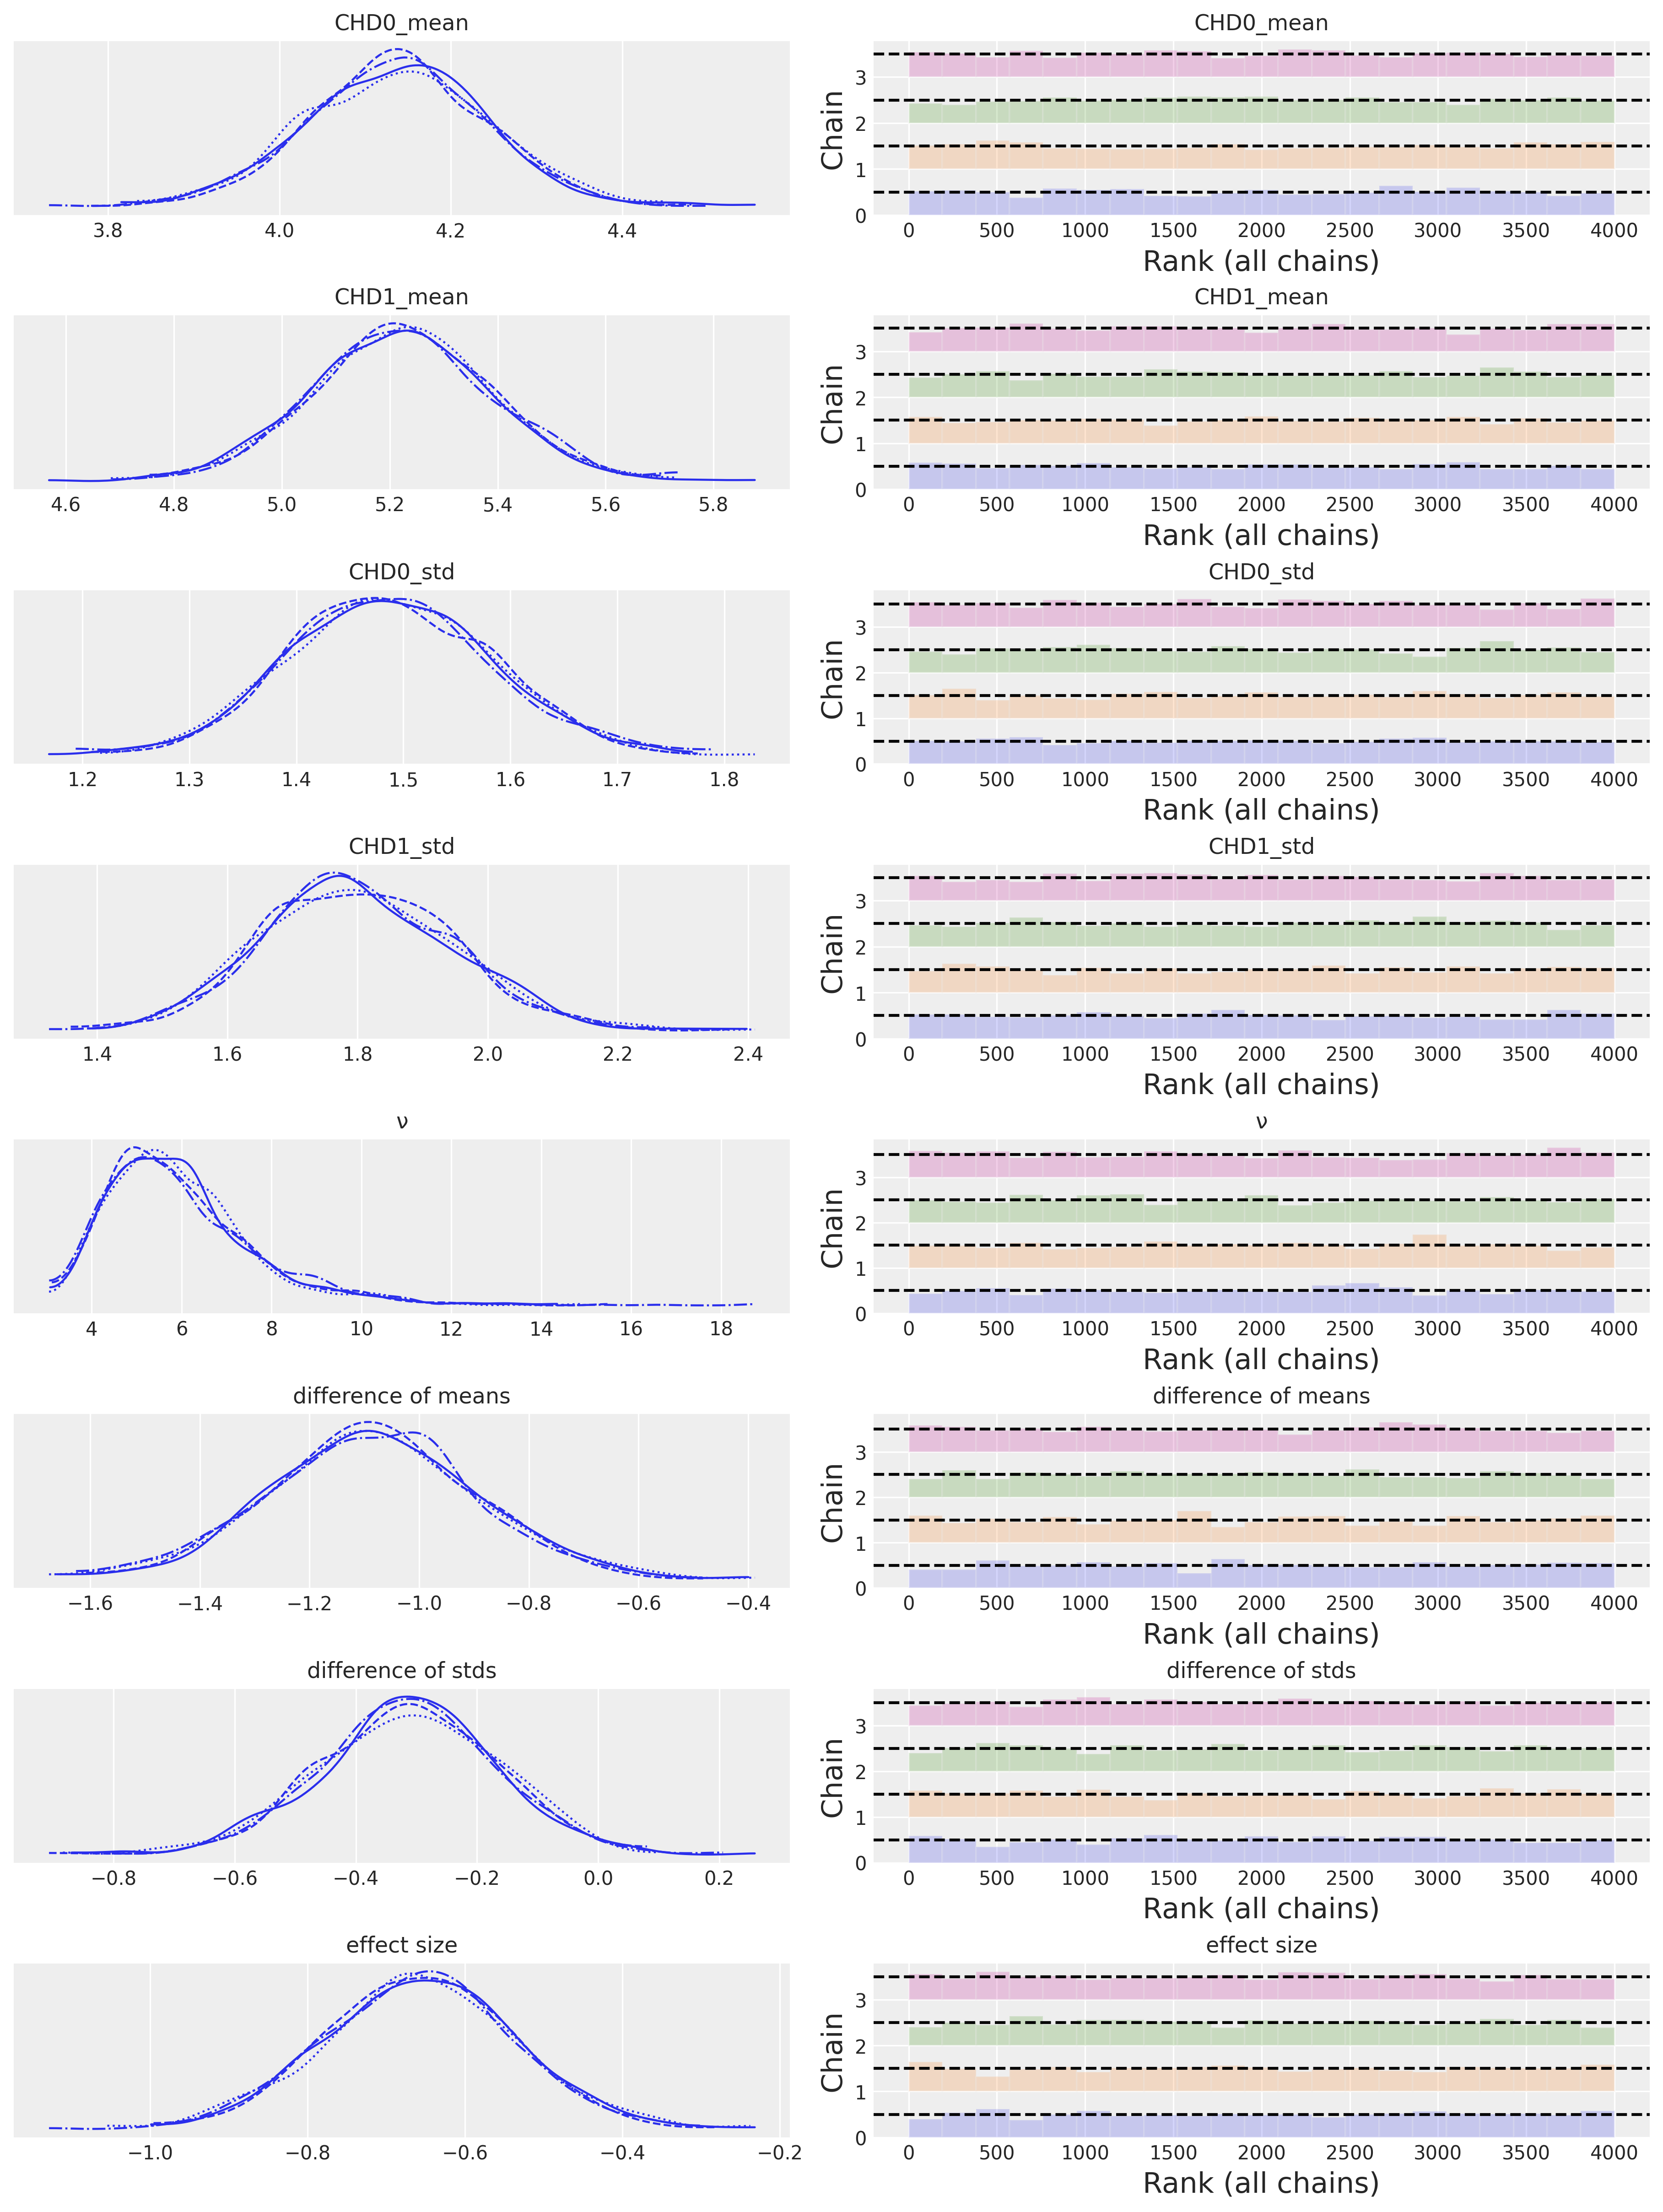

In [10]:
az.plot_trace(chd_trace, kind = "rank_bars")

In [11]:
chd_pp = pm.sample_posterior_predictive(chd_trace, model = model)


array([<Axes: title={'center': 'No_CHD / No_CHD'}>,
       <Axes: title={'center': 'CHD / CHD'}>], dtype=object)

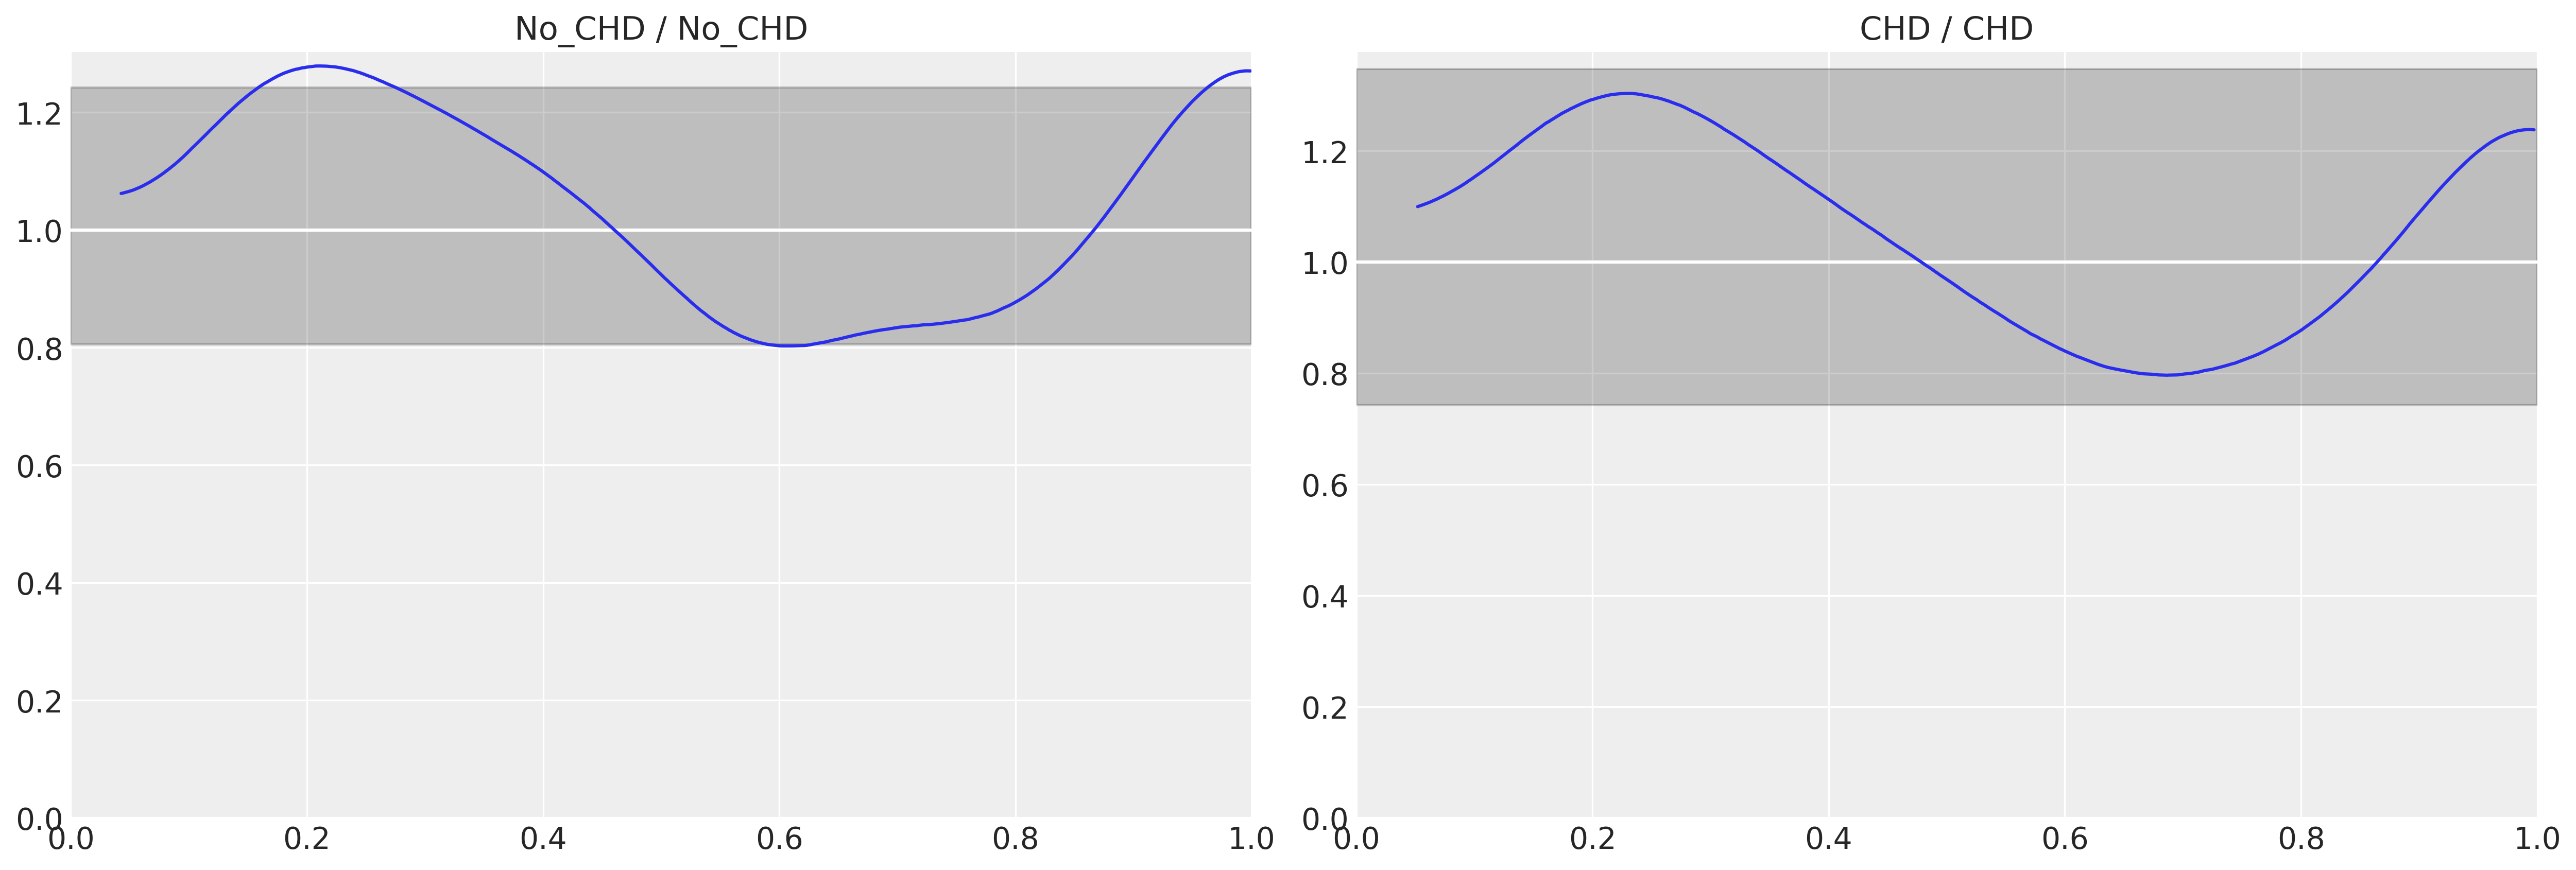

In [12]:
az.plot_bpv(chd_pp)


The graph above suggests well performing sample chains.

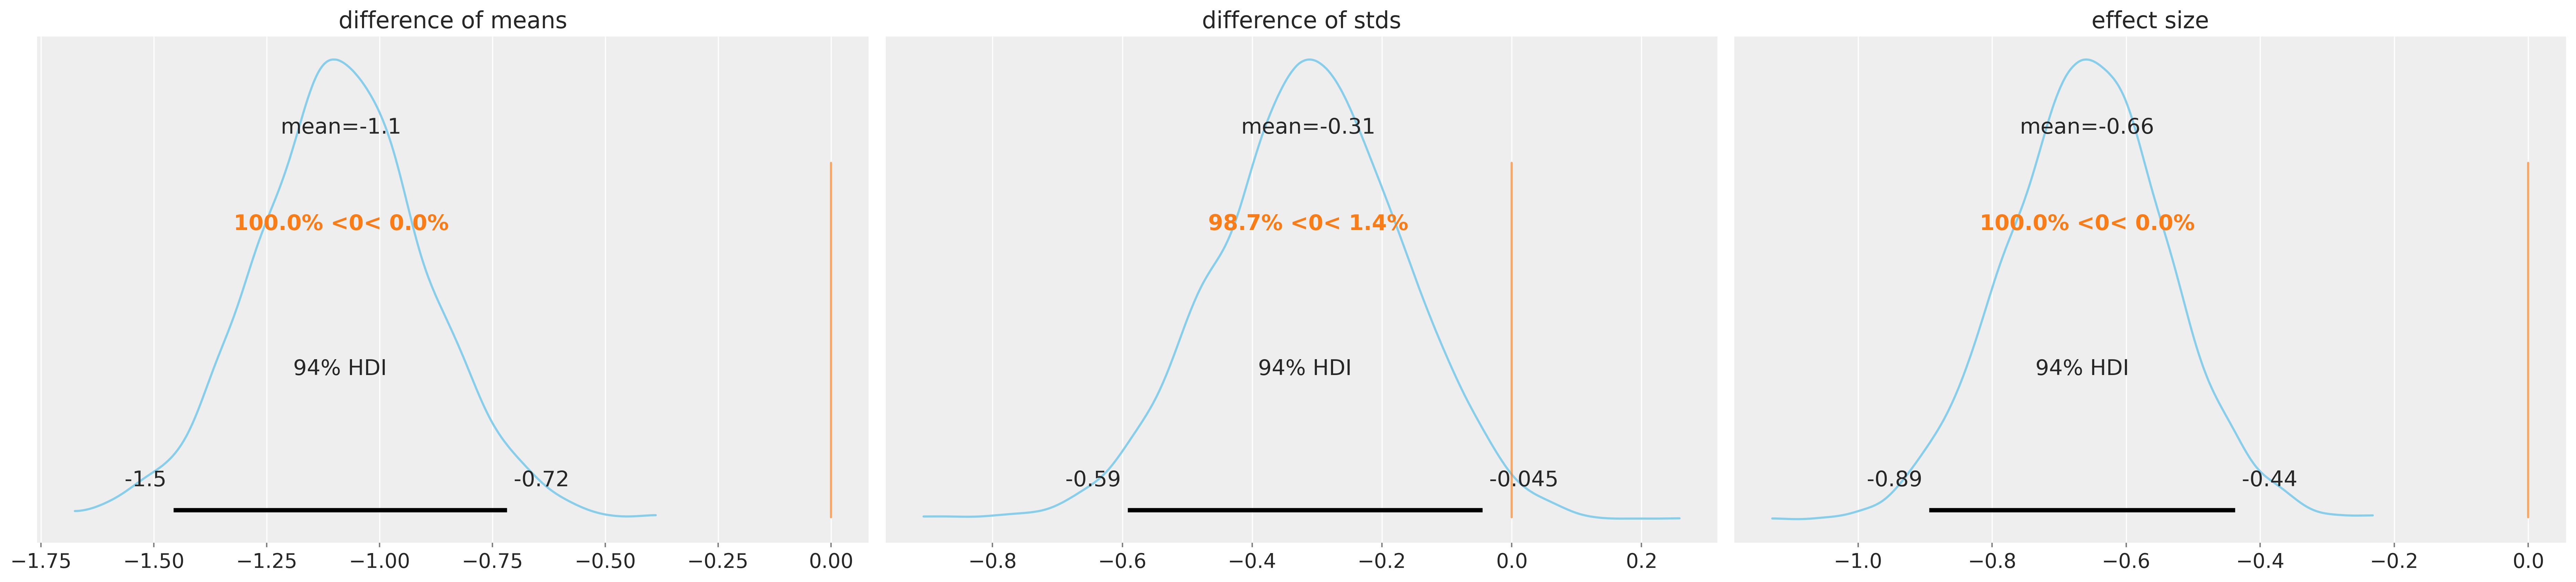

In [13]:
az.plot_posterior(
    chd_trace,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
);

The difference of means graph above suggests that there is a statstically significant difference between ldl in chd vs no chd patients.